In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler

In [ ]:
csv_path = "../data/subdataset.csv"
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


(1168, 15)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,SalePrice
0,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,145000
1,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,178000
2,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,85000
3,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,175000
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,127000


In [22]:
# 1. Price per m^2

df['LotArea_m^2'] = df['LotArea']*0.092903
df['Price_per_m^2'] = df['SalePrice'] / df['LotArea_m^2']

- A	Agriculture
- C	Commercial
- **FV	Floating Village Residential**
- I	Industrial
- **RH	Residential High Density**
- **RL	Residential Low Density**
- RP	Residential Low Density Park 
- **RM	Residential Medium Density**

In [31]:
# 2. Property Development index ( PDI )
scaler = MinMaxScaler()
df['MSZoning'].value_counts()


MSZoning
RL         924
RM         172
FV          53
RH          15
C (all)      4
Name: count, dtype: int64

In [24]:
zoning_mean_price = df.groupby('MSZoning')['SalePrice'].mean().round(2)
print(zoning_mean_price)

MSZoning
C (all)     90450.00
FV         216002.15
RH         131462.27
RL         190339.91
RM         129463.94
Name: SalePrice, dtype: float64


In [33]:
df['ZoningScore'] = df['MSZoning'].map(zoning_mean_price)
df['ZoningScore'] = scaler.fit_transform(df[['ZoningScore']])

df[['MSZoning', 'SalePrice', 'ZoningScore']].head(10)
                                                  

,MSZoning,SalePrice,ZoningScore
0,RL,145000,0.795605
1,RL,178000,0.795605
2,RL,85000,0.795605
3,RL,175000,0.795605
4,RL,127000,0.795605
5,RL,149900,0.795605
6,RL,174000,0.795605
7,RM,125500,0.310739
8,RL,175500,0.795605
9,RL,225000,0.795605


In [37]:
df['SubClassScore'] = df['MSSubClass'] / 190
df['LotAreaNorm'] = scaler.fit_transform(df[['LotArea']])
df['PDI'] = (
    0.4 * df['ZoningScore'] + 
    0.3 * df['SubClassScore'] + 
    0.3 * df['LotAreaNorm']
)

In [39]:
# 3. Economic Value Index
df['Price_per_m^2_norm'] = scaler.fit_transform(df[['Price_per_m^2']])
df['EVI'] = (
    0.5 * df['Price_per_m^2_norm'] +
    0.3 * df['ZoningScore'] +
    0.2 * df['SubClassScore']
)

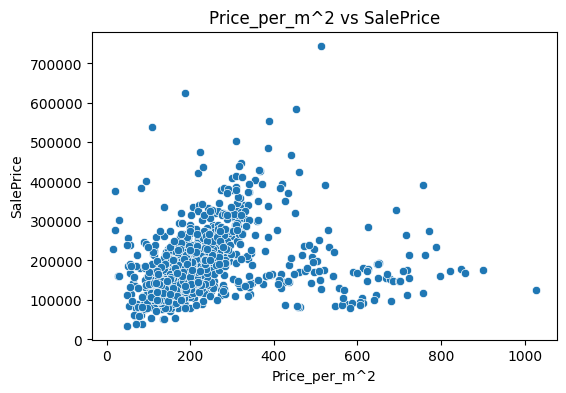

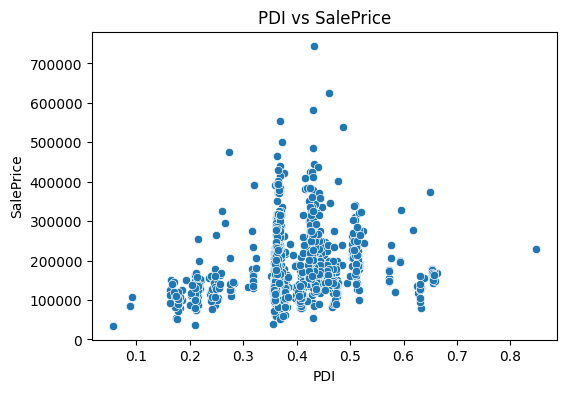

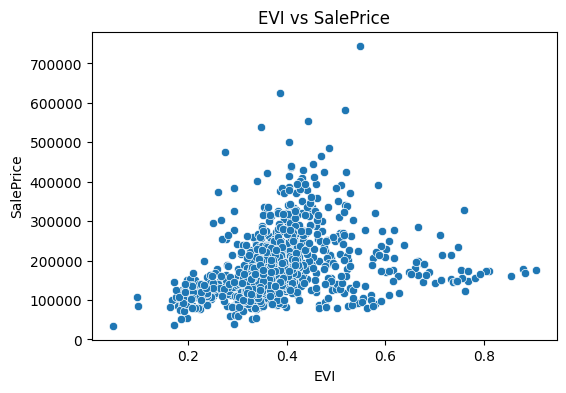

SalePrice        1.000000
EVI              0.299640
Price_per_m^2    0.265210
PDI              0.241289
Name: SalePrice, dtype: float64


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Price_per_m^2', 'PDI', 'EVI']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df['SalePrice'])
    plt.title(f"{feature} vs SalePrice")
    plt.xlabel(feature)
    plt.ylabel("SalePrice")
    plt.show()

corrs = df[features + ['SalePrice']].corr()
print(corrs['SalePrice'].sort_values(ascending=False))


## New Engineered Features

### 1. Price_per_m2  
Formula:  
Price_per_m2 = SalePrice / LotArea (m²)  

Măsoară valoarea terenului per metru pătrat.  
Valori mari indică proprietăți aflate în zone scumpe sau moderne,  
iar valori mici indică terenuri mari sau zone periferice.

---

### 2. Property Development Index (PDI)  
Formula:  
PDI = 0.4 × ZoningScore_norm + 0.3 × SubClassScore_norm + 0.3 × (1 - LotAreaNorm_norm)  

Combină informații despre zonă, tipul construcției și dimensiunea terenului.  
Valori mari sugerează proprietăți moderne, urbane; valori mici – zone rurale sau case vechi.

---

### 3. Economic Value Index (EVI)  
Formula:  
EVI = 0.5 × Price_per_m2_norm + 0.3 × ZoningScore_norm + 0.2 × SubClassScore_norm  

Reflectă valoarea economică totală a locuinței, combinând prețul pe m², densitatea zonei și tipul construcției.  
Valori mari indică proprietăți valoroase în zone bune; valori mici – proprietăți ieftine sau slab urbanizate.

---


In [42]:
df[['Price_per_m^2', 'PDI', 'EVI']].describe().round(2)


,Price_per_m^2,PDI,EVI
count,1168.00,1168.00,1168.00
mean,224.82,0.39,0.38
std,131.12,0.09,0.10
min,14.97,0.06,0.05
25%,148.74,0.36,0.33
50%,191.30,0.38,0.37
75%,253.47,0.43,0.41
max,1026.71,0.85,0.91


In [43]:
df.to_csv("Cornescu_Darius_new_features.csv", index=False)
